In [ ]:
install.packages("BiocManager")

library(BiocManager)
library(tidyverse) 

install("edgeR")
install("limma")
BiocManager::install("EnhancedVolcano")
install.packages("readxl")
install.packages("dplyr")
install.packages("caret")
install.packages("glmnet", repos = "https://cran.us.r-project.org")
install.packages("Hmisc")
BiocManager::install("biomaRt")
install.packages("pROC")
BiocManager::install("clusterProfiler")
BiocManager::install("org.Hs.eg.db")

In [ ]:
library(limma)
library(edgeR)
library(EnhancedVolcano)

library(readxl)
library(dplyr)
library(caret)
library(R.utils)
library(readr)
library(ggplot2)
library(tidyr)
library(gplots)
library(tibble)

library(fastDummies)
library(glmnet)
library(corrplot)
library(coefplot)
library(Hmisc)
library("biomaRt")
library(pROC)
library(clusterProfiler)
library(org.Hs.eg.db)

# Data preprocessing for DGE analysis

In [5]:
unlink("/kaggle/working", recursive = TRUE)

In [6]:
### Upoading samples

setwd("/kaggle/working/")
dir.create("./downloaded_data/fib_rnaseq/untar/", recursive = TRUE)
setwd("downloaded_data/fib_rnaseq")

url0 <- "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE221921&format=file&file=GSE221921%5FFM%5FProcessedData%2Exlsx"
download.file(url0, destfile="GSE221921_FM_ProcessedData.xlsx", mode="wb") 

url1 <- "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE221921&format=file"
download.file(url1, destfile="GSE221921_RAW.tar", mode="wb") 
untar("GSE221921_RAW.tar", exdir = "./untar")

gz_files <- list.files(path = "./untar", pattern = "\\.gz$", full.names = TRUE)
for (gz_file in gz_files) {
    gunzip(gz_file, overwrite = TRUE)}

setwd("untar")
file_names <- list.files(pattern = "\\.txt$", full.names = FALSE)

for (file in file_names) {
  current_data <- read.table(file, header = TRUE)
  data_unique <- current_data[!duplicated(current_data$gene), ]
  data_unique <- data_unique[data_unique$gene != "NA", ]
  new_file_name <- gsub("^GSM\\d+_(Sample_\\d+)\\.txt$", "\\1.txt", file)
  write.table(data_unique, new_file_name, row.names = FALSE, sep = "\t")
}

In [7]:
# Demographic data
sample_info <- read_excel("/kaggle/working/downloaded_data/fib_rnaseq/GSE221921_FM_ProcessedData.xlsx", sheet = 2)
head(sample_info)

Sample,Etiology,Gender
<chr>,<chr>,<chr>
Sample_278,Control,Male
Sample_282,Control,Female
Sample_284,Control,Female
Sample_286,Control,Male
Sample_312,Control,Male
Sample_314,Control,Female


In [8]:
# Features distribution across samples
table(interaction(sample_info$Gender, sample_info$Etiology))


     Female.Control        Male.Control Female.Fibromyalgia   Male.Fibromyalgia 
                 41                  52                  91                   5 

In [9]:
### Sptitting samples for train and test datasets. DEG analysis and logistic regression was performed on train data only.

set.seed(123)
train_index <- createDataPartition(interaction(sample_info$Gender, sample_info$Etiology), p = 0.8, list = FALSE)
train_data <- sample_info[train_index, ]
test_data <- sample_info[-train_index, ]

# Features distribution for train and test data
table(interaction(train_data$Gender, train_data$Etiology))
table(interaction(test_data$Gender, test_data$Etiology))


     Female.Control        Male.Control Female.Fibromyalgia   Male.Fibromyalgia 
                 33                  42                  73                   4 


     Female.Control        Male.Control Female.Fibromyalgia   Male.Fibromyalgia 
                  8                  10                  18                   1 

In [10]:
train_data_samples <- train_data$Sample
train_data_samples_names <- paste0(train_data_samples, ".txt")

In [11]:
### Reading data in limma-accepted format

dge <- readDGE(train_data_samples_names)
dge$samples <- cbind(dge$samples, train_data)

# Samples info
head(dge$samples)

,files,group,lib.size,norm.factors,Sample,Etiology,Gender
,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>
Sample_286,Sample_286.txt,1,NA,1,Sample_286,Control,Male
Sample_312,Sample_312.txt,1,NA,1,Sample_312,Control,Male
Sample_314,Sample_314.txt,1,NA,1,Sample_314,Control,Female
Sample_316,Sample_316.txt,1,NA,1,Sample_316,Control,Male
Sample_318,Sample_318.txt,1,NA,1,Sample_318,Control,Male
Sample_320,Sample_320.txt,1,NA,1,Sample_320,Control,Male


In [12]:
# Count data info
head(dge$counts)

,Sample_286,Sample_312,Sample_314,Sample_316,Sample_318,Sample_320,Sample_322,Sample_324,Sample_326,Sample_328,⋯,Sample_705,Sample_707,Sample_711,Sample_715,Sample_944,Sample_950,Sample_986,Sample_988,Sample_996,Sample_998
MT-RNR2,5.815548,5.206887,5.158271,5.048537,5.314118,5.483915,5.531386,5.785995,5.064006,4.923721,⋯,4.849246,5.298044,6.221360,3.743908,4.542588,4.960142,5.351844,5.247425,5.120530,5.532617
RN7SL1,5.393373,5.200443,5.149082,5.106198,5.010202,5.003958,5.076562,5.218789,4.993960,4.950309,⋯,5.812551,5.624658,5.834508,5.043533,4.516736,5.012240,5.132096,5.286326,5.038809,5.087102
MT-RNR1,5.649055,5.253262,5.123267,5.102709,5.242764,5.376853,5.362125,5.605851,5.120400,5.215553,⋯,4.961712,5.310376,5.936377,5.143614,4.474291,4.928562,5.275856,6.020394,5.060863,5.495654
SNORD17,4.620340,4.968959,5.362872,4.910250,4.866621,4.772746,5.223716,5.326831,5.283016,4.984970,⋯,6.098531,5.340038,5.648839,4.618357,4.916165,5.557128,5.409011,5.137899,5.538931,5.535426
SNORA73B,5.272311,5.014990,4.944534,5.035092,4.994891,4.965550,4.943343,4.957580,4.752133,4.961206,⋯,5.492781,5.446974,5.577898,5.044576,4.669836,5.193257,5.201109,4.941083,5.181332,5.228598
SNORA73A,4.887733,4.708198,1.610414,3.939596,4.763138,4.685884,3.718669,4.727958,4.547476,4.414177,⋯,5.171868,5.416127,5.242560,2.408051,4.415753,4.997738,4.991594,4.778458,4.633974,4.921235


Warning message:
“Removed 152 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_density()`).”


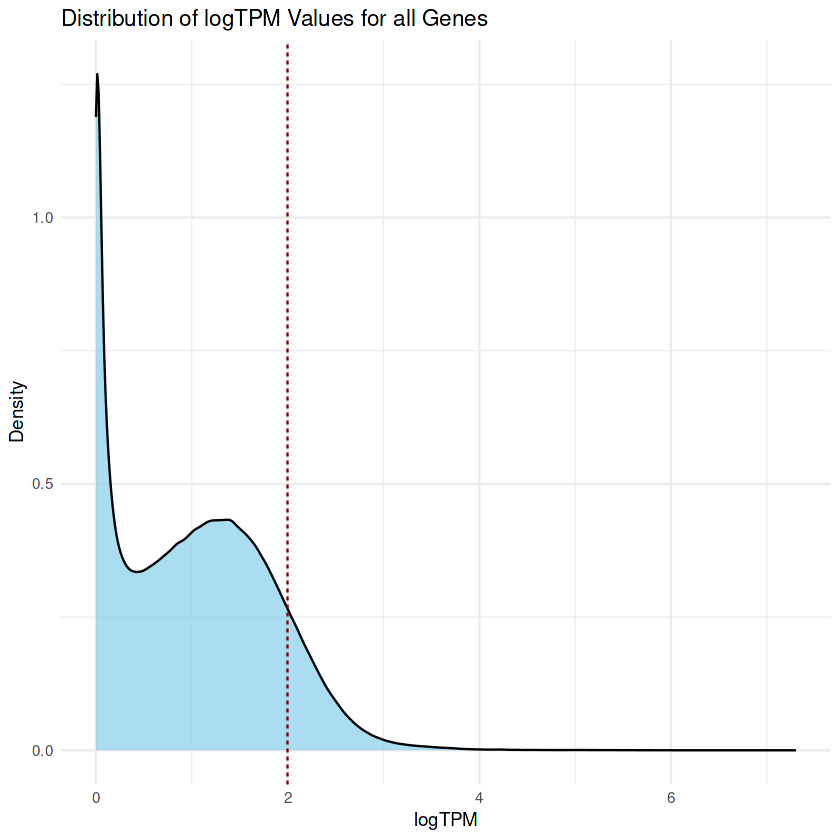

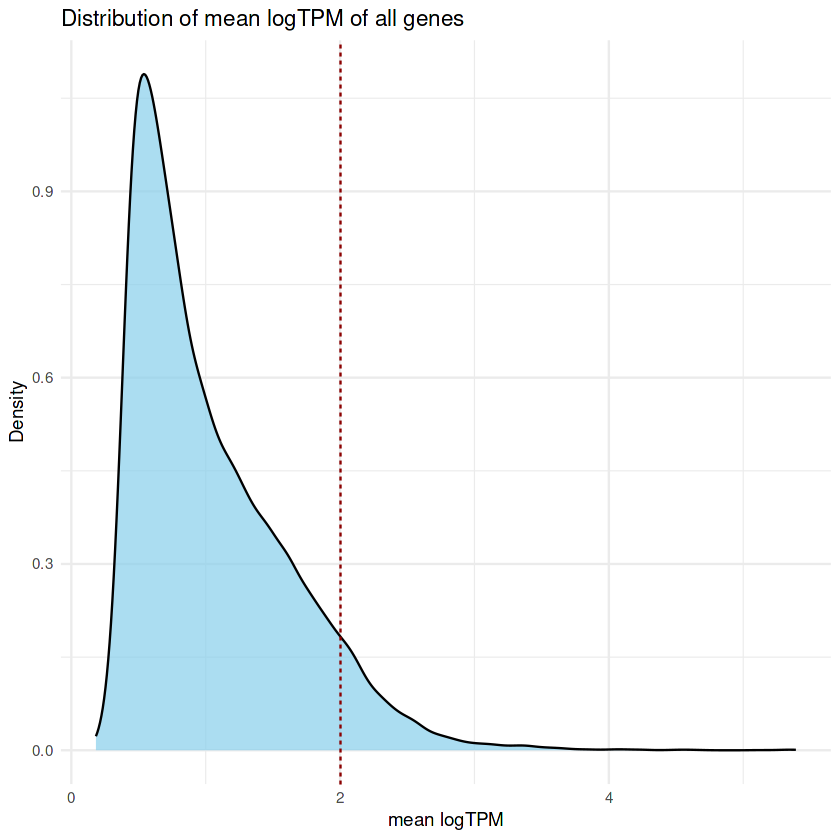

In [13]:
### Creating a density plots of logTPM to select a threshold for filtering low expressed genes

# Convert matrix to long data format
long_logTPM <- dge %>%
   as.data.frame() %>%
   mutate(gene=rownames(dge)) %>%
   pivot_longer(!gene, names_to = "sample", values_to = "logTPM")

# Create a density plot of logTPM values across all samples
 ggplot(long_logTPM, aes(x=logTPM)) +
   geom_density(fill = "skyblue", color = "black", alpha = 0.7) +
   geom_vline(xintercept = 2, color = "darkred", linetype = "dashed", linewidth = 0.5) + 
   labs(title = "Distribution of logTPM Values for all Genes",
        x = "logTPM",
        y = "Density") +
   theme_minimal()

# Density plot of average logTPM per gene.
  gene_mean_logTPM <- long_logTPM %>%
    group_by(gene) %>%
    summarise(mean_logTPM = mean(logTPM))

   ggplot(gene_mean_logTPM, aes(x=mean_logTPM)) +
    geom_density(fill = "skyblue", color = "black", alpha = 0.7)+
    geom_vline(xintercept = 2, color = "darkred", linetype = "dashed", linewidth = 0.5) + 
    labs(title="Distribution of mean logTPM of all genes",
         x="mean logTPM",
         y="Density") +
     theme_minimal()

In [14]:
### Filtering genes with absent info for any sample
rows_with_na <- apply(dge$counts, 1, function(row) any(is.na(row)))
print(sum(rows_with_na))
dge <- dge[!rows_with_na, ]

[1] 1


In [15]:
# Set a minimum CPM threshold
min_logtpm <- 2 # Minimum logTPM threshold
min_samples <- round(152 * 0.7)  # Minimum number of samples with logTPM above the threshold (70%)

# Create a logical vector indicating which genes to keep
keep_logtpm <- rowSums(dge$counts >= min_logtpm) >= min_samples

# Subset the DGEList object
dge_filtered <- dge[keep_logtpm, ]

# See how many genes are filtered out
dim(dge)
dim(dge_filtered)

[1] 21374   152

[1] 1110  152

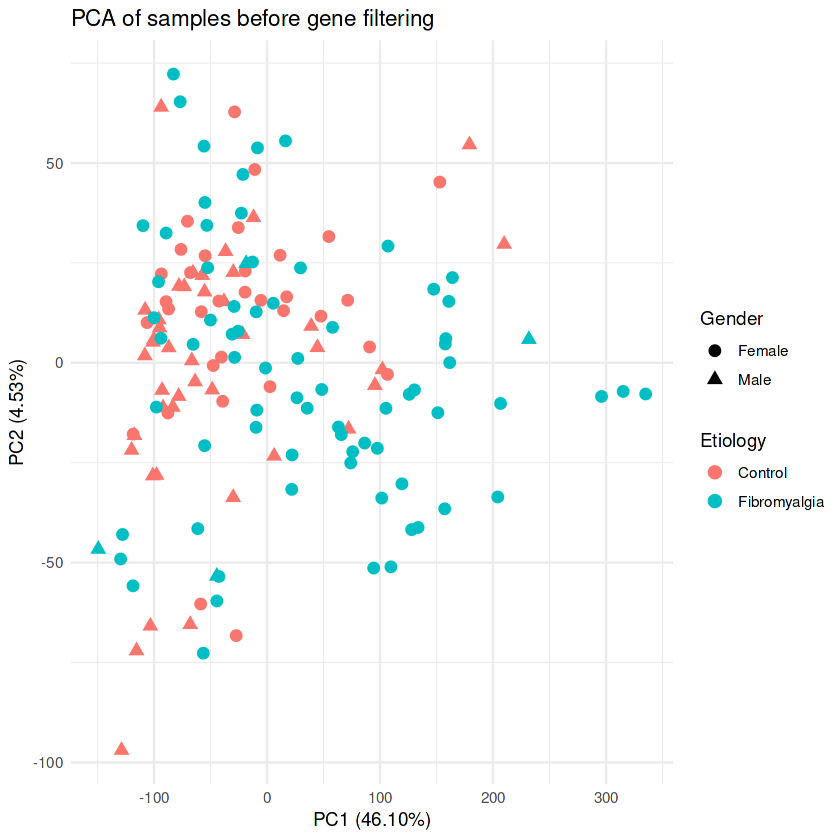

In [16]:
### Build PCA plots based gene expression BEFORE filtering

etiology <- dge$samples$Etiology
gender <- dge$samples$Gender

# Perform PCA
pca_result <- prcomp(t(dge$counts), center = TRUE, scale. = TRUE)

# Create a data frame for plotting
pca_df <- data.frame(pca_result$x[, 1:2])  # First two principal components
pca_df$Sample <- rownames(pca_df)

# Add sample annotation to pca data frame
pca_df$Etiology <- etiology  
pca_df$Gender <- gender     

# Calculate percentages of variance explained
pca_var <- pca_result$sdev^2
pca_var_percent <- pca_var / sum(pca_var) * 100

# Format the percentages to have two decimals
pc1_percentage <- sprintf("%.2f", pca_var_percent[1])
pc2_percentage <- sprintf("%.2f", pca_var_percent[2])

# Plot PCA using multiple geoms with color and shape
ggplot(pca_df, aes(x = PC1, y = PC2)) +
  geom_point(aes(shape = Gender, colour = Etiology), size = 3)  + 
  labs(
    x = paste0("PC1 (", pc1_percentage, "%)"),
    y = paste0("PC2 (", pc2_percentage, "%)")
  ) +
  ggtitle("PCA of samples before gene filtering") +
  theme_minimal()


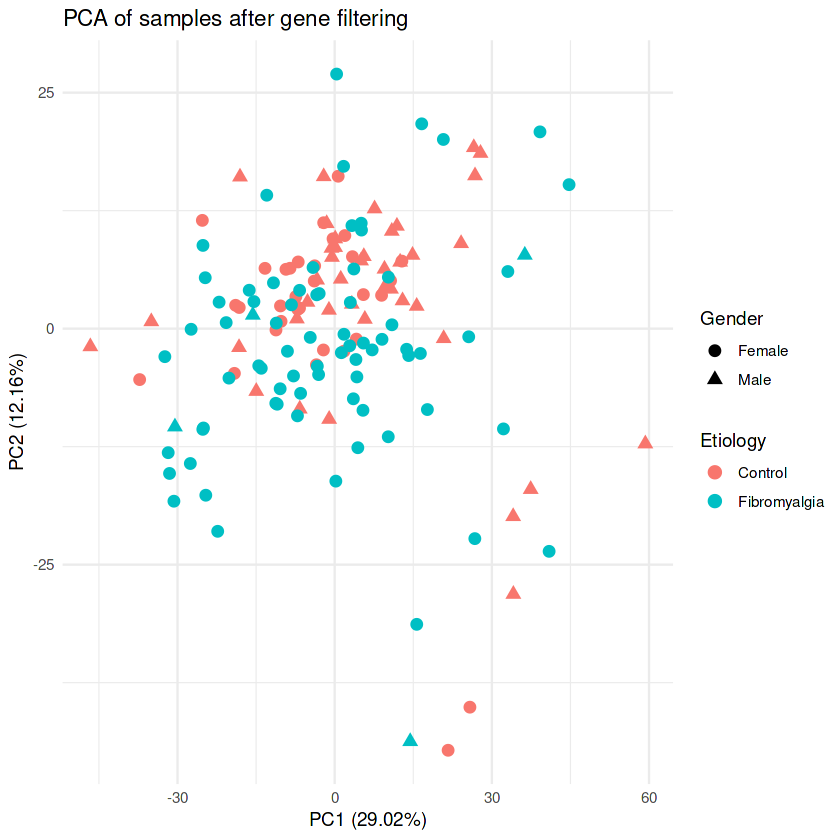

In [17]:
### AFTER filtering
etiology <- dge_filtered$samples$Etiology
gender <- dge_filtered$samples$Gender

pca_result <- prcomp(t(dge_filtered$counts), center = TRUE, scale. = TRUE)

pca_df <- data.frame(pca_result$x[, 1:2])  
pca_df$Sample <- rownames(pca_df)

pca_df$Etiology <- etiology
pca_df$Gender <- gender      

pca_var <- pca_result$sdev^2
pca_var_percent <- pca_var / sum(pca_var) * 100

pc1_percentage <- sprintf("%.2f", pca_var_percent[1])
pc2_percentage <- sprintf("%.2f", pca_var_percent[2])

ggplot(pca_df, aes(x = PC1, y = PC2)) +
  geom_point(aes(shape = Gender, colour = Etiology), size = 3) + 
  labs(
    x = paste0("PC1 (", pc1_percentage, "%)"),
    y = paste0("PC2 (", pc2_percentage, "%)")
  ) +
  ggtitle("PCA of samples after gene filtering") +
  theme_minimal()

# DGE analysis

In [117]:
# Create design matrix
design <- model.matrix(~0+etiology+gender)

# Estimate weigts to partily recover library sizes
arrayw <- arrayWeights(dge_filtered$counts)

# DGE analysis
fit <- lmFit(dge_filtered$counts, design, weights=arrayw)
fit <- eBayes(fit, trend=TRUE)
fit_res <- topTable(fit, coef=ncol(design), number = Inf)

# Print genes with lowest adjusted p values
topTable(fit, coef=ncol(design))

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
KDM5C,-0.2594078,2.364795,-5.827472,3.198263e-08,3.550072e-05,8.514047
UBA1,-0.1230400,2.437855,-5.084207,1.060648e-06,5.886594e-04,5.289249
TMEM63A,-0.1993571,2.488183,-4.607080,8.519571e-06,2.420054e-03,3.381081
SCARNA7,-0.3432447,2.770458,-4.601545,8.720917e-06,2.420054e-03,3.359752
SEMA4D,-0.1562348,2.415427,-4.539141,1.133338e-05,2.516011e-03,3.120609
MALAT1,-0.3303255,3.386964,-4.440454,1.706633e-05,2.745632e-03,2.747447
GRAP2,-0.2166122,2.488790,-4.436942,1.731480e-05,2.745632e-03,2.734281
SNORA74B,-0.3382097,4.034638,-4.295353,3.080377e-05,4.274023e-03,2.210166
RIPOR2,-0.1277455,2.630177,-4.197256,4.556205e-05,5.619320e-03,1.854771


In [19]:
### Approaches to select potential signature genes for RSRS

# “Top-p” approach: 100 genes with the smallest adjusted p values
top_min_p_adj <- fit_res %>%
  arrange(adj.P.Val) %>%
  slice_head(n = 100)

# “Top-fold” approach:top-100 genes ranked by fold change and with p value less than 0.05
top_max_logfc <- fit_res %>%
  filter(P.Value < 0.05) %>%
  arrange(desc(abs(logFC))) %>%
  slice_head(n = 100)

genelist_top_min_p_adj <- rownames(top_min_p_adj)
genelist <- rownames(top_max_logfc)

# Check the length of gene lists
length(genelist_top_min_p_adj)
length(genelist)

[1] 100

[1] 100

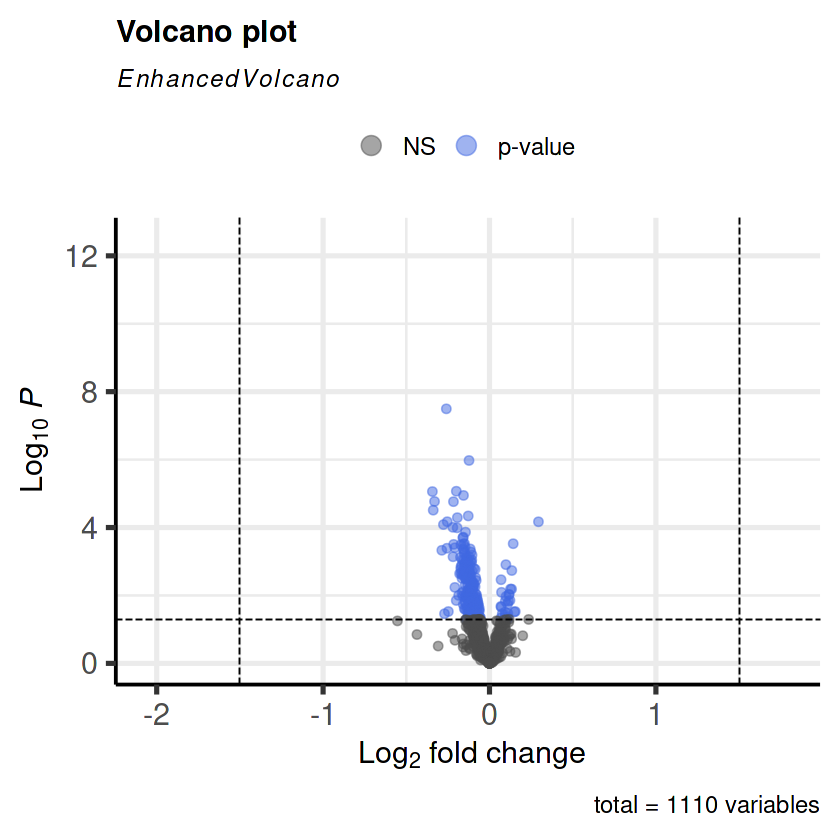

In [20]:
# Volcano plot
EnhancedVolcano(fit_res,
    lab = rownames(fit_res),
    x = 'logFC',
    y = 'P.Value',
    pCutoff = 0.05,
    FCcutoff=1.5)

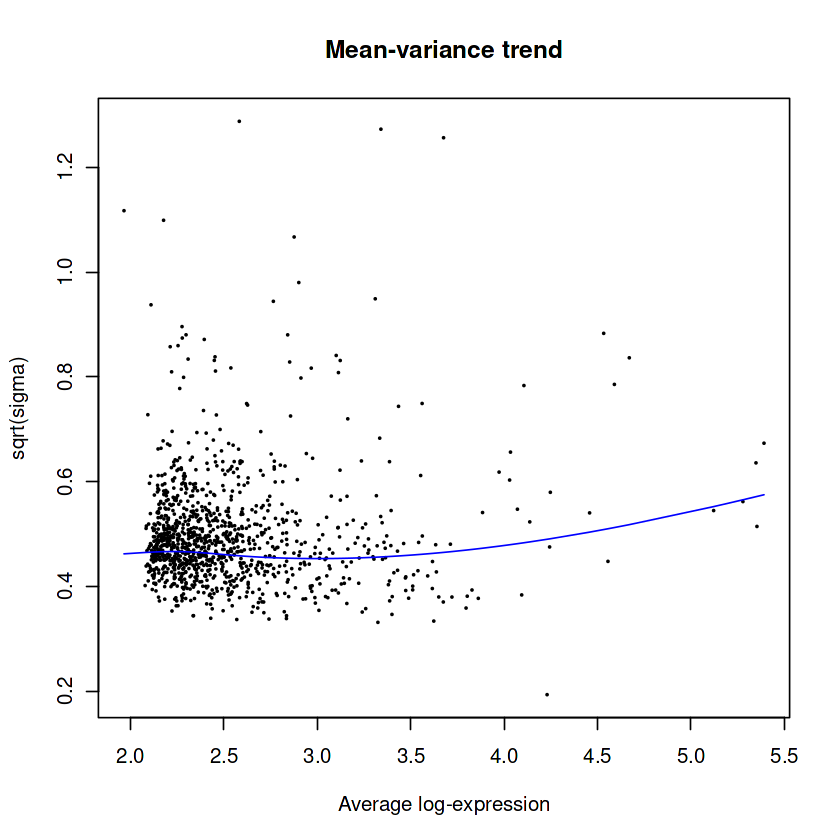

In [21]:
# Mean-variance trend plot
plotSA(fit, main="Mean-variance trend")

# Data preprocessing for Lasso logistic regression

In [159]:
# Creating gene expression matrix for "Top-p” and “Top-fold” approach

file_list <- list.files(pattern = "^Sample_", full.names = FALSE)
full_list <- readDGE(file_list)$counts

rows_with_na <- apply(full_list, 1, function(row) any(is.na(row)))
full_list <- full_list[!rows_with_na, ]
full_list <- as.data.frame(t(full_list))  
                      
genelist_top_min_p_adj <- rownames(top_min_p_adj)
genelist_top_max_logfc <- rownames(top_max_logfc)

# Dataset for "Top-p” approach (will then have the index ‘1’ in the variable name)
df1 <- full_list %>%
    rownames_to_column("Sample") %>%
    dplyr::select(any_of(c("Sample", genelist_top_min_p_adj)))

# Dataset for "Top-fold” approach (will then have the index ‘2’ in the variable name)
df2 <- full_list %>%
    rownames_to_column("Sample") %>%
    dplyr::select(any_of(c("Sample", genelist_top_max_logfc)))

In [160]:
# Adding the disease status and gender data for each sample
sample_info_transformed <- dummy_cols(sample_info,
                           select_columns = c("Etiology", "Gender"),
                           remove_selected_columns = TRUE,
                           remove_first_dummy = TRUE)

merged_df1 <- left_join(df1, sample_info_transformed, by = "Sample")
merged_df2 <- left_join(df2, sample_info_transformed, by = "Sample")

head(sample_info_transformed)

Sample,Etiology_Fibromyalgia,Gender_Male
<chr>,<int>,<int>
Sample_278,0,1
Sample_282,0,0
Sample_284,0,0
Sample_286,0,1
Sample_312,0,1
Sample_314,0,0


In [189]:
# Splitting dataset on test and training, based on previous splitting results (see "Data preprocessing for DGE analysis" section)
train_data_samples <- train_data$Sample
test_data_samples <- test_data$Sample

train_merged_df1 <- merged_df1 %>%
    filter(Sample %in% train_data_samples) %>%
    tibble::column_to_rownames("Sample")
train_merged_df2 <- merged_df2 %>%
    filter(Sample %in% train_data_samples) %>%
    tibble::column_to_rownames("Sample")

test_merged_df1 <- merged_df1 %>%
    filter(Sample %in% test_data_samples) %>%
    tibble::column_to_rownames("Sample")
test_merged_df2 <- merged_df2 %>%
    filter(Sample %in% test_data_samples) %>%
    tibble::column_to_rownames("Sample")

#  Lasso logistic regression
## "Top-p" approach

In [190]:
### Getting feature matrix (X) and target variable (Y) for train and test datasets

X_train_df1 <- train_merged_df1 %>% dplyr::select(-Etiology_Fibromyalgia)
Y_train_df1 <- train_merged_df1$Etiology_Fibromyalgia

X_test_df1 <- test_merged_df1 %>% dplyr::select(-Etiology_Fibromyalgia)
Y_test_df1 <- test_merged_df1$Etiology_Fibromyalgia

In [192]:
### Data standartisation
X_train_stand_df1_no_gender <- X_train_df1 %>% dplyr::select(-Gender_Male)
mean_values_1 <- colMeans(X_train_stand_df1_no_gender)
std_values_1 <- apply(X_train_stand_df1_no_gender, 2, sd)

# Creating matrix without gender info
X_train_stand_df1_no_gender <- scale(X_train_stand_df1_no_gender, center = mean_values_1, scale = std_values_1)
X_train_stand_df1 <- cbind(X_train_stand_df1_no_gender, Gender_Male=X_train_df1$Gender_Male)

# Applying mean and SD calculated for train data on test data 
X_test_stand_df1_no_gender <- X_test_df1 %>% dplyr::select(-Gender_Male)
X_test_stand_df1_no_gender <- scale(X_test_stand_df1_no_gender, center = mean_values_1, scale = std_values_1)
X_test_stand_df1 <- cbind(X_test_stand_df1_no_gender, Gender_Male=X_test_df1$Gender_Male)


Call:  cv.glmnet(x = X_train_stand_df1_no_gender, y = Y_train_df1, family = "binomial") 

Measure: Binomial Deviance 

     Lambda Index Measure      SE Nonzero
min 0.02753    23   1.047 0.17447      22
1se 0.09228    10   1.218 0.08548       7


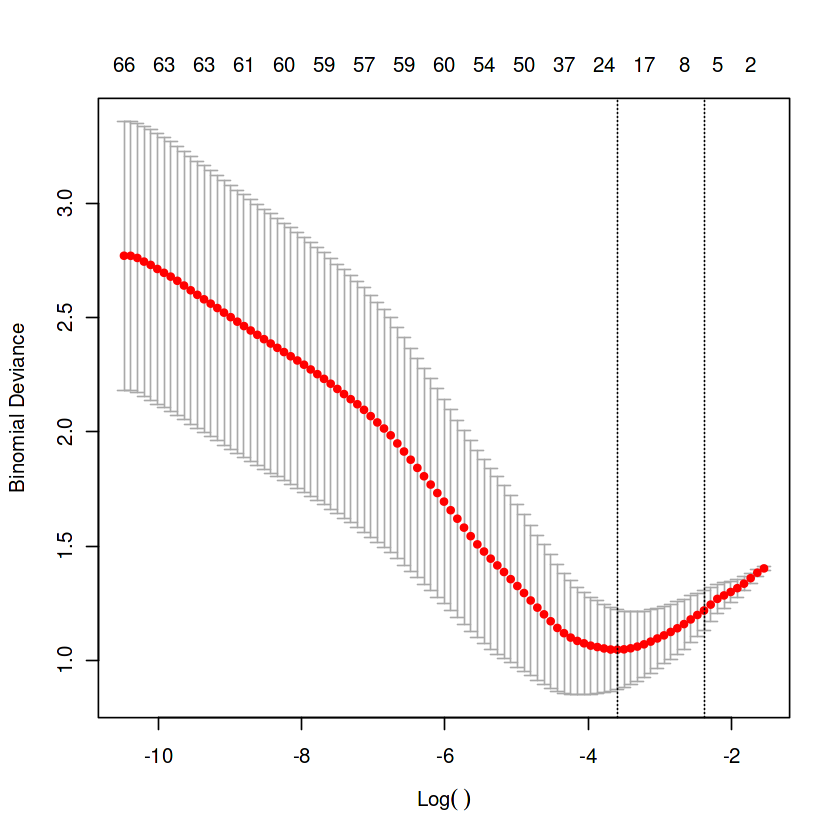

In [193]:
### Fitting the model
set.seed(123)
cvfit <- cv.glmnet(X_train_stand_df1_no_gender, Y_train_df1, family = "binomial") #, type.measure = "auc", keep = TRUE)

# Cross validation curve
plot(cvfit)

# Print best lambda values and number of genes with nonzero weights
print(cvfit)

In [194]:
# Using lambda that gives minimum mean cross-validated error
coef_at_min <- coef(cvfit, s = "lambda.min")
nonzero_coef_1 <- extract.coef(cvfit)
genelist_nonzero_coef_1 <- rownames(nonzero_coef_1)[-1]

# Print intersept and genes with nonzero coefficents
nonzero_coef_1

,Value,SE,Coefficient
,<dbl>,<dbl>,<chr>
(Intercept),0.07740809,NA,(Intercept)
KDM5C,0.02629486,NA,KDM5C
UBA1,0.27810078,NA,UBA1
SNORA74B,0.57140306,NA,SNORA74B
ZMIZ2,0.03364906,NA,ZMIZ2
R3HDM4,-0.44797941,NA,R3HDM4
CTSZ,-0.15589182,NA,CTSZ
TRAF3IP3,-0.38334715,NA,TRAF3IP3
DPYD,0.40750312,NA,DPYD


ERROR: Error in data.frame(..., check.names = FALSE): arguments imply differing number of rows: 529, 506


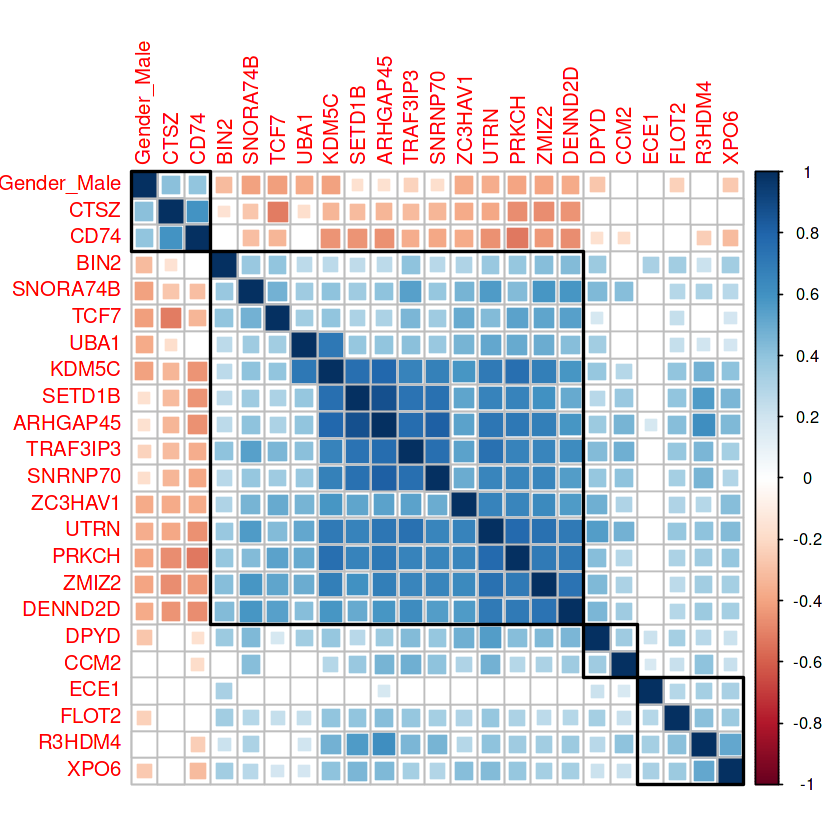

In [195]:
### Calculating pair wise correlation (gender data included)
rcorr_result <- rcorr(as.matrix(X_train_stand_df1[, c(genelist_nonzero_coef_1, "Gender_Male"), drop=FALSE])) ## X_train_stand_df1 TO SEE WITH GENDER !!!
cor_df1 <- rcorr_result$r
p_values_matrix_1 <- rcorr_result$P

### Correlation plot (values with p > 0.05 are white), order of variables is based on hierarcial clusterring
corrplot(cor_df1,
  method = "square",
  # type = "upper",
  order = "hclust",
  addrect = 4,
  p.mat = p_values_matrix_1, 
  sig.level = 0.05,
  insig = "blank") 

In [197]:
### Prediction on test dataset
prediction_test <- predict(cvfit, newx = X_test_stand_df1_no_gender, family = "binomial", s = "lambda.min", type='response')
prediction_test_measures <- assess.glmnet(cvfit, newx = X_test_stand_df1_no_gender, newy = Y_test_df1, family = "binomial", s = "lambda.min")

# Accuracy measures
prediction_test_measures

$deviance
lambda.min 
  1.156193 
attr(,"measure")
[1] "Binomial Deviance"

$class
lambda.min 
 0.2432432 
attr(,"measure")
[1] "Misclassification Error"

$auc
[1] 0.7719298
attr(,"measure")
[1] "AUC"

$mse
lambda.min 
 0.3934729 
attr(,"measure")
[1] "Mean-Squared Error"

$mae
lambda.min 
 0.7335389 
attr(,"measure")
[1] "Mean Absolute Error"

Setting levels: control = 0, case = 1

Warning message in roc.default(Y_test_df1, prediction_test):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



95% CI: 0.6183-0.9255 (DeLong)

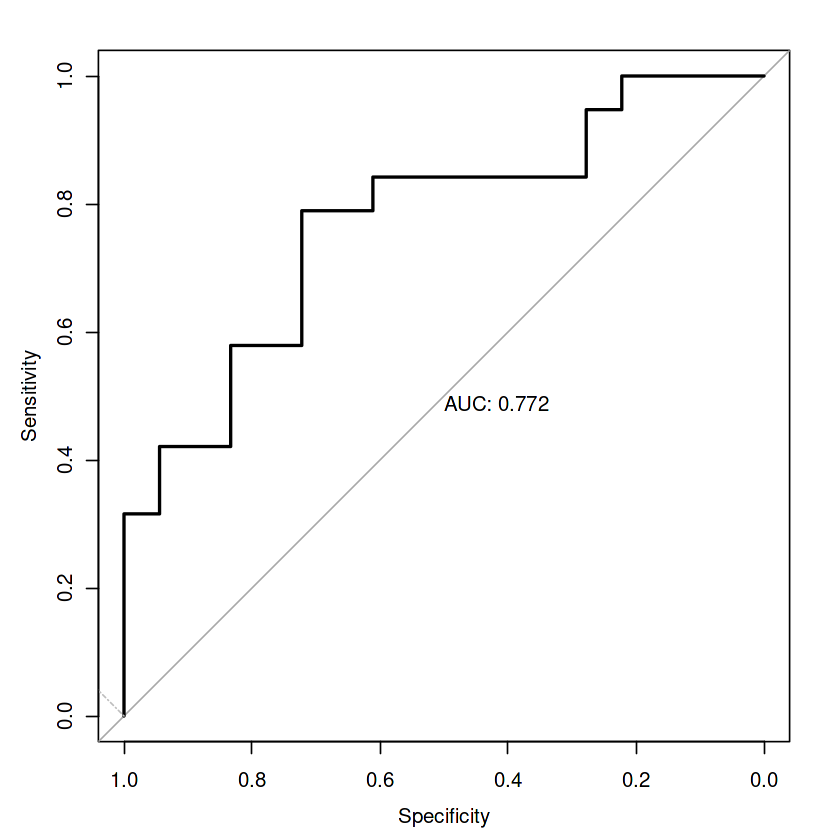

In [198]:
### AUC ROC 
Y_test_df1 <- as.factor(Y_test_df1)
roc_obj <- roc(Y_test_df1, prediction_test) # swapped arguments
auc_value <- auc(roc_obj)
auc_ci <- ci.auc(roc_obj)

# Print AUC confidence intervals 
auc_ci 

# Plorring ROC
plot(roc_obj, col = "black", print.auc=TRUE)
lines(c(0, 1), col = "gray", lty = 4)

## "Top-fold" approach

In [199]:
### Same steps as for "Top-p" approach are used, see code above for more in-depth comments

### Getting feature matrix (X) and target variable (Y) for train and test datasets
X_train_df2 <- train_merged_df2 %>% dplyr::select(-Etiology_Fibromyalgia)
Y_train_df2 <- train_merged_df2$Etiology_Fibromyalgia
X_test_df2 <- test_merged_df2 %>% dplyr::select(-Etiology_Fibromyalgia)
Y_test_df2 <- test_merged_df2$Etiology_Fibromyalgia

### Data standartisation
X_train_stand_df2_no_gender <- X_train_df2 %>% dplyr::select(-Gender_Male)
mean_values_2 <- colMeans(X_train_stand_df2_no_gender)
std_values_2 <- apply(X_train_stand_df2_no_gender, 2, sd)

X_train_stand_df2_no_gender <- scale(X_train_stand_df2_no_gender, center = mean_values_2, scale = std_values_2)
X_train_stand_df2 <- cbind(X_train_stand_df2_no_gender, Gender_Male=X_train_df2$Gender_Male)

X_test_stand_df2_no_gender <- X_test_df2 %>% dplyr::select(-Gender_Male)
X_test_stand_df2_no_gender <- scale(X_test_stand_df2_no_gender, center = mean_values_2, scale = std_values_2)
X_test_stand_df2 <- cbind(X_test_stand_df2_no_gender, Gender_Male=X_test_df2$Gender_Male)


Call:  cv.glmnet(x = X_train_stand_df2_no_gender, y = Y_train_df2, family = "binomial") 

Measure: Binomial Deviance 

     Lambda Index Measure      SE Nonzero
min 0.02422    25   1.018 0.11380      22
1se 0.06740    14   1.118 0.06527       7


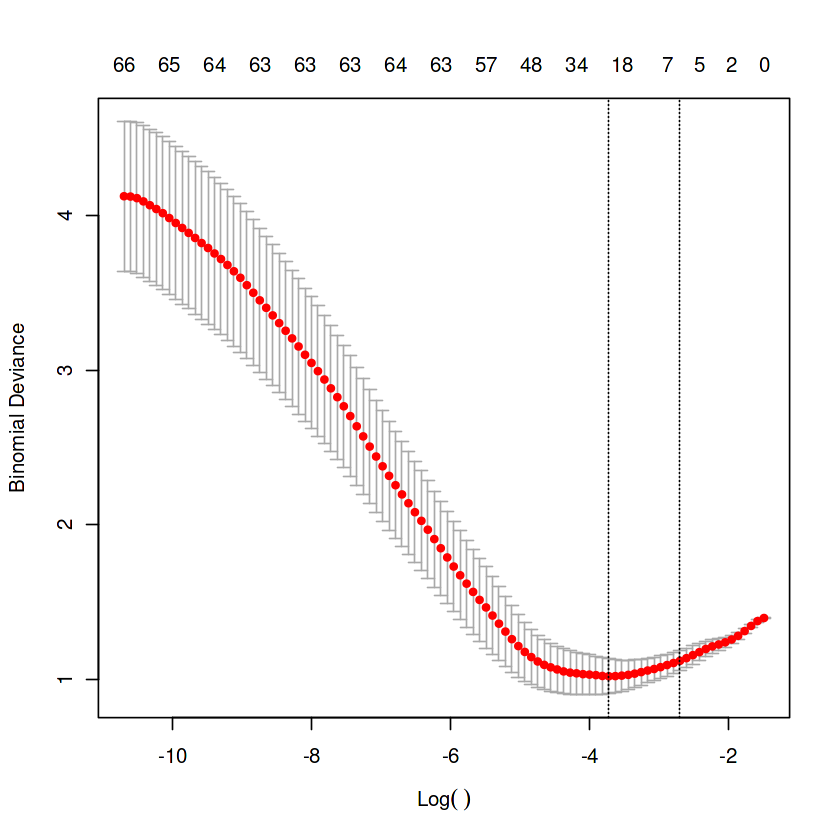

In [200]:
### Fitting the model
set.seed(123)
cvfit2 <- cv.glmnet(X_train_stand_df2_no_gender, Y_train_df2, family = "binomial") #, type.measure = "auc", keep = TRUE)

plot(cvfit2)
print(cvfit2)

In [201]:
# Getting the list of genes with nonzero weights
coef_at_min_2 <- coef(cvfit2, s = "lambda.min")
nonzero_coef_2 <- extract.coef(cvfit2)
genelist_nonzero_coef_2 <- rownames(nonzero_coef_2)[-1]

ERROR: Error in data.frame(..., check.names = FALSE): arguments imply differing number of rows: 529, 506


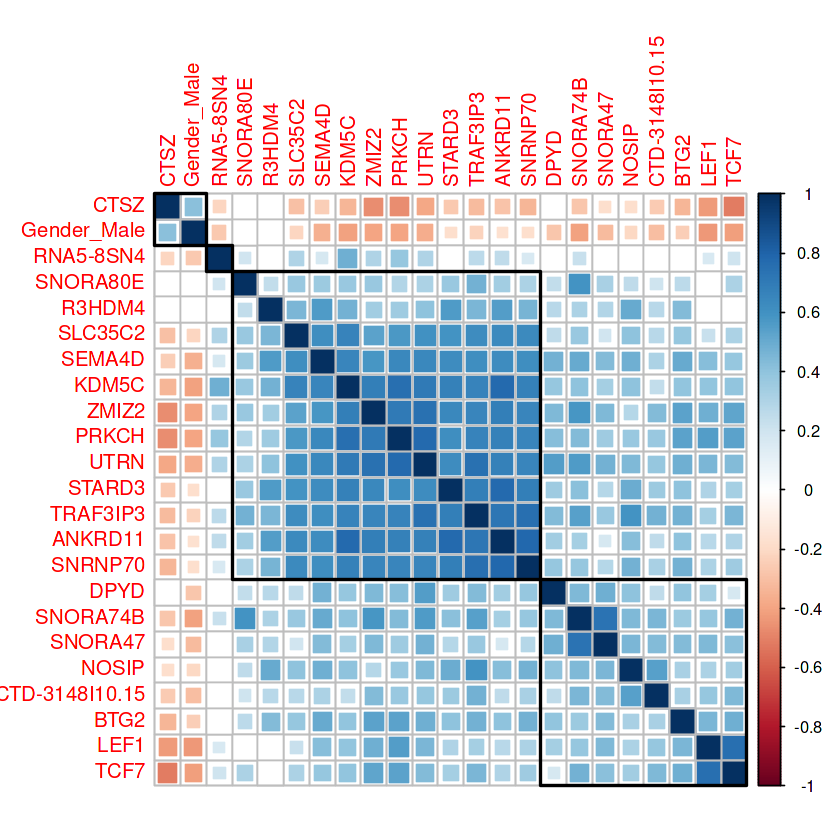

In [202]:
### Correlation of features (with gender)
rcorr_result2 <- rcorr(as.matrix(X_train_stand_df2 [, c(genelist_nonzero_coef_2, "Gender_Male"), drop=FALSE])) 
cor_df2 <- rcorr_result2$r
p_values_matrix_2 <- rcorr_result2$P

corrplot(cor_df2,
  method = "square",
  # type = "upper",
  order = "hclust",
  addrect = 4,
  p.mat = p_values_matrix_2, 
  sig.level = 0.05,
  insig = "blank") 

In [204]:
### Disease status prediction on test dataset
prediction_test2 <- predict(cvfit2, newx = X_test_stand_df2_no_gender, family = "binomial", s = "lambda.min", type='response')
prediction_test_measures2 <- assess.glmnet(cvfit2, newx = X_test_stand_df2_no_gender, 
                                           newy = Y_test_df2, family = "binomial", s = "lambda.min")
prediction_test_measures2

$deviance
lambda.min 
  1.267458 
attr(,"measure")
[1] "Binomial Deviance"

$class
lambda.min 
 0.2702703 
attr(,"measure")
[1] "Misclassification Error"

$auc
[1] 0.7426901
attr(,"measure")
[1] "AUC"

$mse
lambda.min 
 0.4112344 
attr(,"measure")
[1] "Mean-Squared Error"

$mae
lambda.min 
 0.7291284 
attr(,"measure")
[1] "Mean Absolute Error"

Setting levels: control = 0, case = 1

Warning message in roc.default(Y_test_df2, prediction_test2):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



95% CI: 0.5697-0.9157 (DeLong)

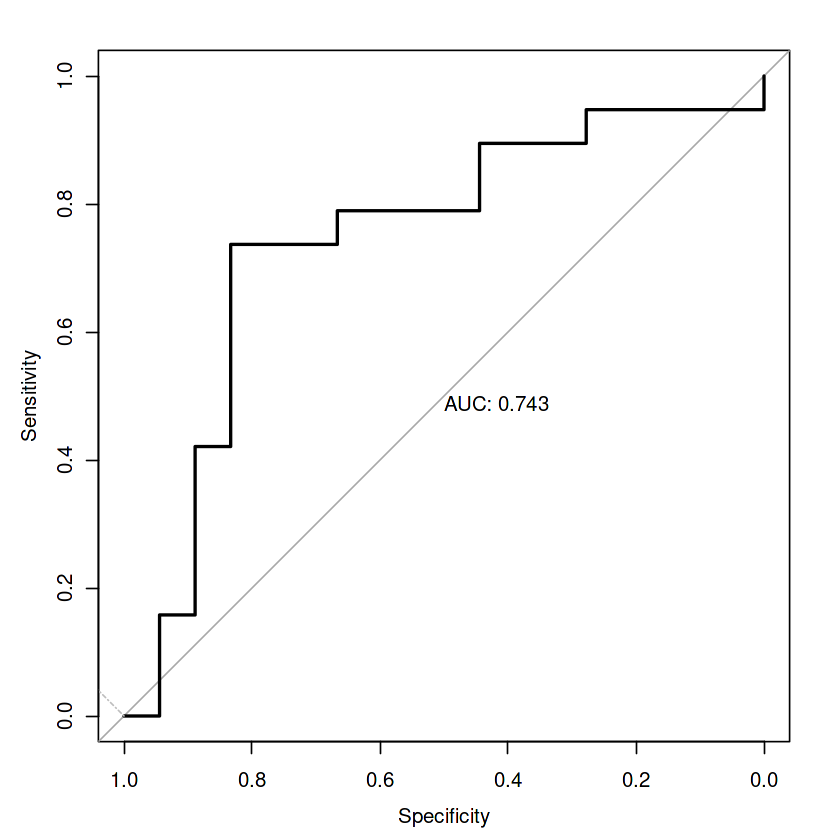

In [206]:
# AUC ROC

Y_test_df2 <- as.factor(Y_test_df2)
roc_obj <- roc(Y_test_df2, prediction_test2) # swapped arguments
auc_value <- auc(roc_obj)
auc_ci <- ci.auc(roc_obj)

auc_ci

plot(roc_obj, col = "black", print.auc=TRUE)
lines(c(0, 1), col = "gray", lty = 4)

# Gene annotation and enrichment analysis

In [180]:
### Gene anotation

# Merging the gene lists 
nonzero_coef_full <- nonzero_coef_1 %>% 
    full_join(nonzero_coef_2, by = c("Coefficient", "SE"), suffix=c("_df1", "_df2")) %>% 
    rename("hgnc_symbol" = "Coefficient")

fit_res_renamed <- fit_res %>%
   tibble::rownames_to_column(var = "hgnc_symbol")

# Getting chromosome and gene description from Ensembl database
ensembl <- useMart("ensembl", dataset="hsapiens_gene_ensembl")
attributes <- c("hgnc_symbol", "chromosome_name", "description")
gene_annotations_full <- getBM(attributes=attributes,
                            filters="hgnc_symbol",
                            values=nonzero_coef_full$hgnc_symbol,
                            mart=ensembl)
gene_annotations_full <- gene_annotations_full %>%
  mutate(description = gsub(" \\[Source:.*", "", description))

# Combine DEG logistic regretion and annotation results
combined_data_full <- nonzero_coef_full %>%
  left_join(fit_res_renamed, by = "hgnc_symbol") %>%
  left_join(gene_annotations_full, by = "hgnc_symbol")

# Calcilating Odds ratio from weights
combined_data_full$odds_ratio_df1 <- exp(combined_data_full$Value_df1)
combined_data_full$odds_ratio_df2 <- exp(combined_data_full$Value_df2)
combined_data_full <- subset(combined_data_full, select = -c(SE))
head(combined_data_full)

,Value_df1,hgnc_symbol,Value_df2,logFC,AveExpr,t,P.Value,adj.P.Val,B,chromosome_name,description,odds_ratio_df1,odds_ratio_df2
,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,0.07740809,(Intercept),0.07942533,NA,NA,NA,NA,NA,NA,NA,NA,1.0804829,1.0826647
2,0.02629486,KDM5C,0.32842056,-0.2594078,2.364795,-5.827472,3.198263e-08,3.550072e-05,8.5140472,X,lysine demethylase 5C,1.0266436,1.3887729
3,0.27810078,UBA1,NA,-0.1230400,2.437855,-5.084207,1.060648e-06,5.886594e-04,5.2892488,X,ubiquitin like modifier activating enzyme 1,1.3206193,NA
4,0.57140306,SNORA74B,0.59458676,-0.3382097,4.034638,-4.295353,3.080377e-05,4.274023e-03,2.2101659,5,"small nucleolar RNA, H/ACA box 74B",1.7707498,1.8122819
5,0.03364906,ZMIZ2,0.14281940,-0.1603591,2.238009,-3.809266,2.010900e-04,1.240055e-02,0.5133458,7,zinc finger MIZ-type containing 2,1.0342216,1.1535215
6,-0.44797941,R3HDM4,-0.53312347,-0.1503200,2.113175,-3.704741,2.946868e-04,1.554249e-02,0.1700632,19,R3H domain containing 4,0.6389178,0.5867693


In [181]:
setwd("/kaggle/working/downloaded_data/fib_rnaseq")
write.table(combined_data_full, file = "combined_data_full.txt", sep = "\t", row.names = FALSE, quote = FALSE, na = "")

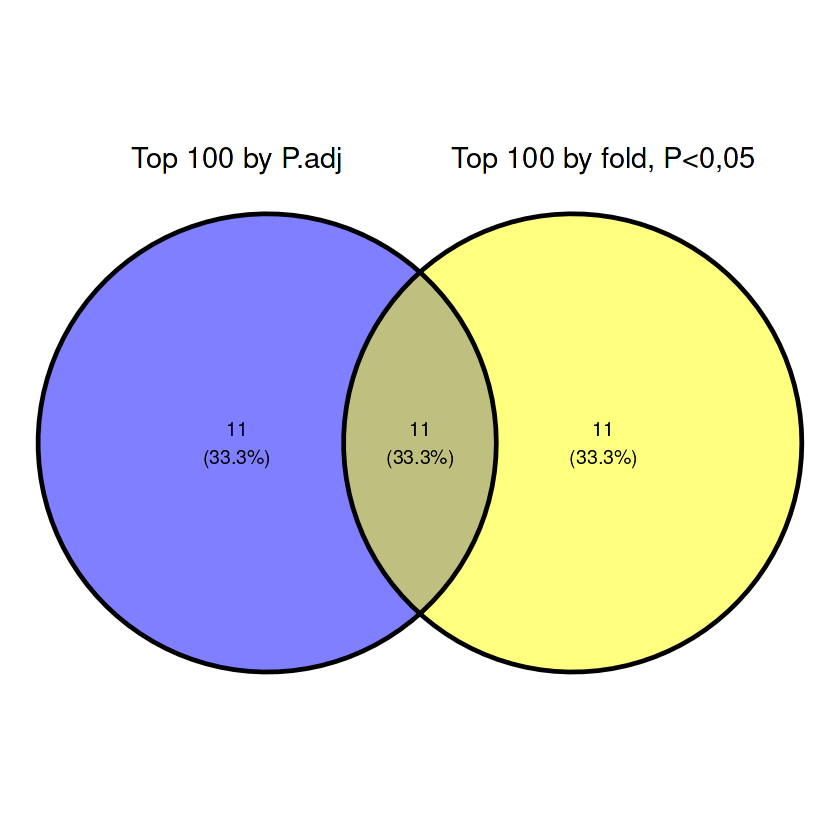

In [186]:
# # install.packages("ggvenn") 
# # library(ggvenn)

# a <- list('Top 100 by P.adj' = genelist_nonzero_coef_1,
#           'Top 100 by fold, P<0,05' = genelist_nonzero_coef_2)

# ggvenn(a)

# fit2 <- euler(a)
# plot(fit2, quantities = TRUE)

In [214]:
### GO enrichment analysis

# For "Top-p" approach
go_results1 <- enrichGO(gene = genelist_nonzero_coef_1,
                        OrgDb = org.Hs.eg.db,  # For human genes
                        keyType = "SYMBOL",
                        ont = "ALL",  # Biological Process
                        pAdjustMethod = "BH",
                        pvalueCutoff = 1,
                        qvalueCutoff = 1)

# View results
head(go_results1, 10)
dim(go_results1)

,ONTOLOGY,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0016486,BP,GO:0016486,peptide hormone processing,2/20,36/18888,0.055555556,52.466667,10.063108,0.0006567441,0.1400754,0.09873969,CTSZ/ECE1,2
GO:0001990,BP,GO:0001990,regulation of systemic arterial blood pressure by hormone,2/20,39/18888,0.051282051,48.430769,9.653435,0.0007709868,0.1400754,0.09873969,CTSZ/ECE1,2
GO:0140448,BP,GO:0140448,signaling receptor ligand precursor processing,2/20,40/18888,0.050000000,47.220000,9.527103,0.0008110501,0.1400754,0.09873969,CTSZ/ECE1,2
GO:0003044,BP,GO:0003044,regulation of systemic arterial blood pressure mediated by a chemical signal,2/20,47/18888,0.042553191,40.187234,8.757399,0.0011190506,0.1400754,0.09873969,CTSZ/ECE1,2
GO:0032481,BP,GO:0032481,positive regulation of type I interferon production,2/20,73/18888,0.027397260,25.873973,6.932470,0.0026760189,0.1400754,0.09873969,TRAF3IP3/ZC3HAV1,2
GO:0050886,BP,GO:0050886,endocrine process,2/20,93/18888,0.021505376,20.309677,6.077555,0.0043013222,0.1400754,0.09873969,CTSZ/ECE1,2
GO:0003073,BP,GO:0003073,regulation of systemic arterial blood pressure,2/20,96/18888,0.020833333,19.675000,5.972323,0.0045761584,0.1400754,0.09873969,CTSZ/ECE1,2
GO:0050863,BP,GO:0050863,regulation of T cell activation,3/20,382/18888,0.007853403,7.416754,4.125004,0.0072462726,0.1400754,0.09873969,CD74/TCF7/FLOT2,3
GO:0032479,BP,GO:0032479,regulation of type I interferon production,2/20,124/18888,0.016129032,15.232258,5.176730,0.0075186188,0.1400754,0.09873969,TRAF3IP3/ZC3HAV1,2


[1] 740  13

In [218]:
# For "Top-fold" approach

go_results2 <- enrichGO(gene = genelist_nonzero_coef_2,
                        OrgDb = org.Hs.eg.db,
                        keyType = "SYMBOL",
                        ont = "ALL",
                        pAdjustMethod = "BH",
                        pvalueCutoff = 1,
                        qvalueCutoff = 1)

head(go_results2, 10)
dim(go_results2)

,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:1990907,GO:1990907,beta-catenin-TCF complex,2/20,13/19894,0.15384615,153.03077,17.394284,7.440011e-05,0.003720005,0.002897688,LEF1/TCF7,2
GO:0033116,GO:0033116,endoplasmic reticulum-Golgi intermediate compartment membrane,2/20,81/19894,0.02469136,24.56049,6.740223,2.966426e-03,0.074160655,0.057767247,SLC35C2/CTSZ,2
GO:0005793,GO:0005793,endoplasmic reticulum-Golgi intermediate compartment,2/20,133/19894,0.01503759,14.95789,5.123465,7.789538e-03,0.099720581,0.077677084,SLC35C2/CTSZ,2
GO:0070938,GO:0070938,contractile ring,1/20,10/19894,0.10000000,99.47000,9.880401,1.001018e-02,0.099720581,0.077677084,UTRN,1
GO:0002116,GO:0002116,semaphorin receptor complex,1/20,13/19894,0.07692308,76.51538,8.639935,1.299462e-02,0.099720581,0.077677084,SEMA4D,1
GO:0016010,GO:0016010,dystrophin-associated glycoprotein complex,1/20,18/19894,0.05555556,55.26111,7.306055,1.794970e-02,0.099720581,0.077677084,UTRN,1
GO:0031527,GO:0031527,filopodium membrane,1/20,18/19894,0.05555556,55.26111,7.306055,1.794970e-02,0.099720581,0.077677084,UTRN,1
GO:0071004,GO:0071004,U2-type prespliceosome,1/20,18/19894,0.05555556,55.26111,7.306055,1.794970e-02,0.099720581,0.077677084,SNRNP70,1
GO:0071010,GO:0071010,prespliceosome,1/20,18/19894,0.05555556,55.26111,7.306055,1.794970e-02,0.099720581,0.077677084,SNRNP70,1


[1] 50 12

In [217]:
write.table(go_results1, file = "go_results1.txt", sep = "\t", row.names = FALSE, quote = FALSE, na = "")
write.table(go_results2, file = "go_results2.txt", sep = "\t", row.names = FALSE, quote = FALSE, na = "")

In [ ]:
############################    Part 2 (unrelated)    ############################

In [ ]:
# setwd("/kaggle/working/")
# dir.create("./downloaded_data/fib_array/untar/", recursive = TRUE)
# setwd("downloaded_data/fib_array")

# options(timeout = 300)
# url2 <- "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE67311&format=file"
# download.file(url2, destfile="GSE67311_RAW.tar", mode="wb") 
# untar("GSE67311_RAW.tar", exdir = "./untar")

In [ ]:
# BiocManager::install("preprocessCore", configure.args = c(preprocessCore = "--disable-threading"), force= TRUE, update=TRUE, type = "source") 
# BiocManager::install("oligo")

In [ ]:
# library(oligo)

In [ ]:
# setwd("/kaggle/working/downloaded_data/fib_array/untar")

# celFiles <- list.celfiles(listGzipped=TRUE)
# affyRaw <- read.celfiles(celFiles)
# eset <- rma(affyRaw)

In [ ]:
# BiocManager::install("GEOquery")
# library(GEOquery)

In [ ]:
# gse <- getGEO("GSE67311",GSEMatrix=TRUE)
# pheno_data <- phenoData(gse[[1]])
# needed_colnames <- c('title', 'geo_accession','bipolar disorder:ch1','bmi:ch1',
#                      'chronic fatigue syndrome:ch1','diagnosis:ch1','fiqr score:ch1',
#                      'irritable bowel syndrome:ch1','major depression:ch1','migraine:ch1')

# adddata <- pData(pheno_data[,needed_colnames])

In [ ]:
# head(adddata)
# adddata

In [ ]:
# rownames(adddata) <- paste(adddata$geo_accession,"_", adddata$title, ".CEL.gz", sep = "") 
# phenoData(eset) <- AnnotatedDataFrame(adddata)

# tail(pData(eset))

In [ ]:
# nrow(adddata[adddata[["migraine:ch1"]] == 'No', ])
# nrow(adddata[adddata[["migraine:ch1"]] == 'Yes', ])